In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchvision.models as models
from tqdm import tqdm

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16033 sha256=95370f42a4d9d9bc2c473f03707e9564c4bab9076d8b0cea5fabbbeff1f076b9
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch


In [3]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.empty_cache()
    
seed_everything(42)

setting everything to seed 42


In [4]:
device = torch.device('cuda:0')

In [5]:
data_dir = '//kaggle/input/audio-speech-sentiment/TRAIN'
file_csv = '/kaggle/input/audio-speech-sentiment/TRAIN.csv'

In [6]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    X = np.stack([X, X, X])

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V


def normalize(image, mean=None, std=None):
    image = image / 255.0
    if mean is not None and std is not None:
        image = (image - mean) / std
    return image.astype(np.float32)

In [7]:
recordings = sorted(os.listdir(data_dir))

In [8]:
len(recordings)

250

In [9]:
NUM_SAMPLES = 81503
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128

TypeError: Invalid shape (3, 128, 160) for image data

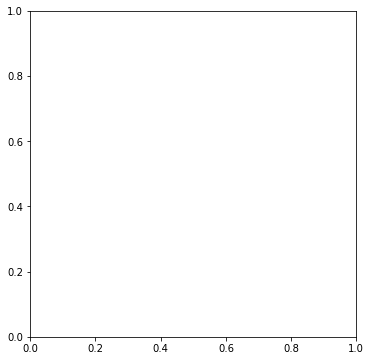

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = mono_to_color(melspec)
melspec = normalize(melspec, mean=None, std=None)
#melspec = self.img_transform(image=melspec)['image']
plt.figure(figsize = (20, 6))
plt.imshow(melspec)

In [11]:
image_size = melspec.shape
image_size

(3, 128, 160)

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    begin = (len(y) - NUM_SAMPLES) // 2
    samples = y[begin:begin + NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = mono_to_color(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    #melspec = self.img_transform(image=melspec)['image']

    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
p_csv = pd.read_csv(file_csv)
files_dict = dict()
Filename = p_csv['Filename']
Class = p_csv['Class']
for i in range(250):
    t = 2
    if Class[i] == 'Negative':
        t = 0
    elif Class[i] == 'Positive':
        t = 1
    files_dict[Filename[i]] = t

In [14]:
# 0 - Negative
# 1 - Positive
# 2 - Neutral

In [15]:
class AudioSpeechSentiment(Dataset):
    def __init__(self, mode = 'train', data_dir='./', train_size=0.8, random_seed=42, recordings=[], files_dict=dict()):
        super().__init__()

        keys = np.arange(len(recordings))
        train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
        if mode == 'train':
            keys = train_keys
        else:
            keys = test_keys
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            #print(recordings[i])
            self.data.append(get_spectrogram(data_dir + '/' + recordings[i]))
            self.labels.append(int(files_dict[recordings[i]]))
        

    def __getitem__(self, i):     
        return self.data[i], self.labels[i]

    def __len__(self):
        return self.n

In [16]:
train_dataset = AudioSpeechSentiment(mode='train', data_dir=data_dir, recordings=recordings, files_dict=files_dict)
test_dataset = AudioSpeechSentiment(mode='test', data_dir=data_dir, recordings=recordings, files_dict=files_dict)

In [17]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [19]:
max_epoch = 30
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [20]:
for epoch in range(max_epoch):
    print('epoch:', epoch)
    model.train()
    #all_ys = []
    #all_preds = []
    sum_loss = 0
    #sum_accuracy = 0
    cnt_objects = 0
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        scores = model(X)
        loss = criterion(scores, y.to(device))
        loss.backward()
        optimizer.step()
        sum_loss += float(loss) * len(y)
        cnt_objects += len(y)

        #all_ys.append(y)
        #all_preds.append(preds)
    mean_loss = sum_loss / cnt_objects
    print('Train')
    print(mean_loss)
    
    model.eval()
    #all_ys = []
    #all_preds = []
    sum_loss = 0
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            sum_loss += float(loss) * len(y)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = (y == preds).float().sum()
            sum_accuracy += accuracy
            cnt_objects += len(y)

            #all_ys.append(y)
            #all_preds.append(preds)

    print('TEST')
    mean_loss = sum_loss / cnt_objects
    mean_accuracy = sum_accuracy / cnt_objects
    print('loss:', mean_loss)
    print('accuracy:', mean_accuracy)
    print('******************')

epoch: 0
Train
0.45114065527915953
TEST
loss: 0.3580043166875839
accuracy: tensor(0.8000)
******************
epoch: 1
Train
0.09882829882204533
TEST
loss: 2.7634761333465576
accuracy: tensor(0.6400)
******************
epoch: 2
Train
0.2517020867019892
TEST
loss: 1.0424539840221405
accuracy: tensor(0.8200)
******************
epoch: 3
Train
0.1488585203886032
TEST
loss: 0.5962909054377815
accuracy: tensor(0.8800)
******************
epoch: 4
Train
0.15339122781530024
TEST
loss: 0.03427817755844444
accuracy: tensor(1.)
******************
epoch: 5
Train
0.03967992583289742
TEST
loss: 0.033134814891961926
accuracy: tensor(0.9800)
******************
epoch: 6
Train
0.009150235508568584
TEST
loss: 0.01447508528304752
accuracy: tensor(1.)
******************
epoch: 7
Train
0.12035106857831124
TEST
loss: 1.8866113824956119
accuracy: tensor(0.7000)
******************
epoch: 8
Train
0.07982300056377425
TEST
loss: 0.14447893554344773
accuracy: tensor(0.9400)
******************
epoch: 9
Train
0.056864